In [1]:
import regex as re
import collections
import nltk.tokenize
import numpy as np
import pandas as pd
import pickle
import seaborn
import matplotlib.pyplot as plt

In [2]:
def tokenize(text):
    # Initialise lists
    tokens = []
    unmatchable = []

    # Compile patterns for speedup
    token_pat = re.compile(r'\w+|\p{Emoji}+') # parts of words and emojis
    skippable_pat = re.compile(r'\s+')  # typically spaces
    # Analyze one line at the time as splicing big chunks of text is highly inefficient
    for line in text.split('\n'):
        # As long as there's any material left...
        while line:
            # Try finding a skippable token delimiter first.
            skippable_match = re.search(skippable_pat, line)
            if skippable_match and skippable_match.start() == 0:
                # If there is one at the beginning of the line, just skip it.
                line = line[skippable_match.end():]
            else:
                # Else try finding a real token.
                token_match = re.search(token_pat, line)
                if token_match and token_match.start() == 0:
                    # If there is one at the beginning of the line, tokenise it.
                    if line[:token_match.end()] != 'user': # skipping censored Twitter handles
                        tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
                else:
                    # Else there is unmatchable material here.
                    # It ends where a skippable or token match starts, or at the end of the line.
                    unmatchable_end = len(line)
                    if skippable_match:
                        unmatchable_end = skippable_match.start()
                    if token_match:
                        unmatchable_end = min(unmatchable_end, token_match.start())
                    # Add it to unmatchable and discard from line.
                    unmatchable.append(line[:unmatchable_end])
                    line = line[unmatchable_end:]
    return tokens

In [24]:
def freq_plot(tokens, voc):
    frq = pd.DataFrame(voc.most_common(), columns=['token', 'frequency'])

    # Index in the sorted list
    frq['idx'] = frq.index + 1

    # Frequency normalised by corpus size
    frq['norm_freq'] = frq.frequency / len(tokens)

    # Cumulative normalised frequency
    frq['cumul_frq'] = frq.norm_freq.cumsum()

    seaborn.set_theme(style='whitegrid')
    
    xlabel = 'Index'
    ylabel = 'Cumulative frequency'
    
    fig, ax = plt.subplots(1, 3)
    
    # Plot: Cumulative frequency by index
    ax[0] = seaborn.relplot(x='idx', y='cumul_frq', data=frq).set_axis_labels(xlabel, ylabel)

    # Plot: Cumulative frequency by index, top 10000 tokens
    ax[1] = seaborn.relplot(x='idx', y='cumul_frq', data=frq[:10000], kind='line').set_axis_labels(xlabel, ylabel)

    # Plot: Log-log plot for Zipf's law
    frq['log_frq'] = np.log(frq.frequency)
    frq['log_rank'] = np.log(frq.frequency.rank(ascending=False))
    ax[2] = seaborn.relplot(x='log_rank', y='log_frq', data=frq)
    fig.show()

In [28]:
tk = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

In [27]:
# each element of this dictionary is a tuple, whose first element is tokens from tokenize()
#                                             and second is from TweetTokenizer()
tokens = dict()
# same as above, but for counters
counters = dict()
# indexes of the above dictionaries
indexes = ['offensive', 'sentiment', 'gatsby']

for idx in indexes:
    if idx == 'gatsby':
        # The Great Gatsby has a different path, we also need to remove Gutenberg's header and footer
        text = open('../data/GreatGatsby.txt', 'r', encoding='utf-8').read().split('***')[2]
    else:
        text = open(f'../data/{idx}/train_text.txt', 'r', encoding='utf-8').read()
    tokens[idx] = (tokenize(text), tk.tokenize(text))
    counters[idx] = (collections.Counter(tokens[idx][0]), collections.Counter(tokens[idx][1]))
    print(idx.capitalize())
    print('-' * len(idx))
    length = len(tokens[idx][0])
    length_counter = len(counters[idx][0])
    print(f"""Our  tokenizer found {length} tokens, {length_counter} of which\
 (or {round(100 * length_counter / length, 2)}%) are unique.""")
    length = len(tokens[idx][1])
    length_counter = len(counters[idx][1])
    print(f"""TweetTokenizer found {length} tokens, {length_counter} of which\
 (or {round(100 * length_counter / length, 2)}%) are unique.\n""")

Offensive
---------
Our  tokenizer found 244967 tokens, 23624 of which (or 9.64%) are unique.
TweetTokenizer found 271263 tokens, 24660 of which (or 9.09%) are unique.

Sentiment
---------
Our  tokenizer found 901635 tokens, 56021 of which (or 6.21%) are unique.
TweetTokenizer found 1015583 tokens, 61972 of which (or 6.1%) are unique.

Gatsby
------
Our  tokenizer found 50004 tokens, 6258 of which (or 12.51%) are unique.
TweetTokenizer found 61266 tokens, 6349 of which (or 10.36%) are unique.



In [6]:
print('20 most common words\n')
for idx in indexes:
    print(f'{idx.capitalize()}:')
    for rank, word in enumerate(counters[idx][0].most_common(20), 1):
        print(f'{rank}. {word[0]} - {word[1]} occurences')
    print()

20 most common words

Offensive:
1. the - 7271 occurences
2. is - 5656 occurences
3. to - 5472 occurences
4. # - 4740 occurences
5. a - 4582 occurences
6. and - 4106 occurences
7. you - 3683 occurences
8. of - 3347 occurences
9. are - 3076 occurences
10. I - 3075 occurences
11. that - 2369 occurences
12. in - 2321 occurences
13. s - 2172 occurences
14. for - 2152 occurences
15. t - 2018 occurences
16. it - 1828 occurences
17. he - 1681 occurences
18. on - 1475 occurences
19. she - 1421 occurences
20. with - 1299 occurences

Sentiment:
1. the - 34873 occurences
2. to - 20673 occurences
3. I - 15273 occurences
4. in - 13130 occurences
5. on - 12573 occurences
6. a - 12202 occurences
7. and - 12015 occurences
8. # - 11494 occurences
9. of - 10683 occurences
10. for - 9669 occurences
11. is - 9269 occurences
12. s - 8502 occurences
13. you - 7939 occurences
14. it - 7700 occurences
15. with - 7352 occurences
16. be - 7096 occurences
17. at - 6902 occurences
18. tomorrow - 6664 occurences
1

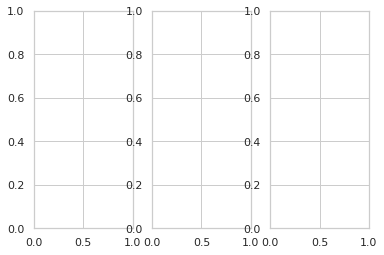

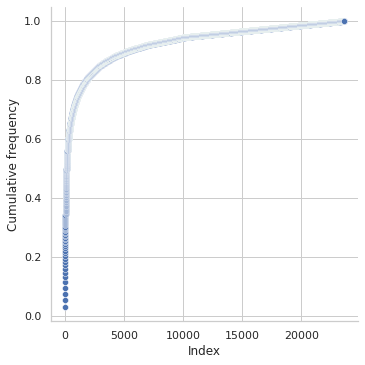

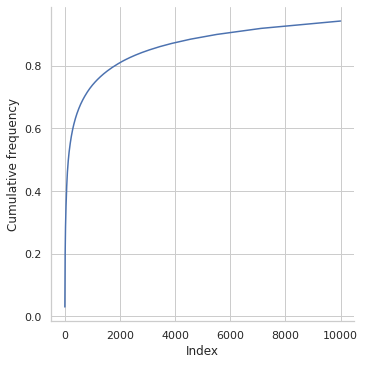

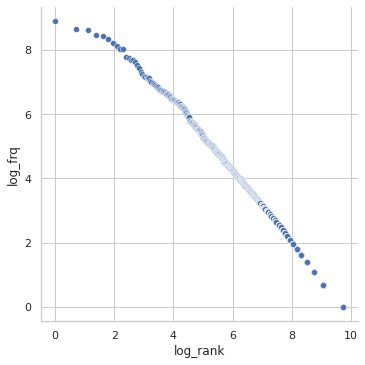

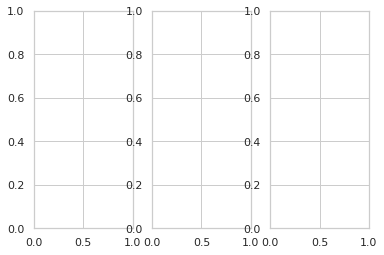

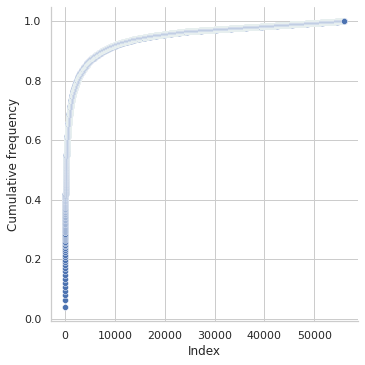

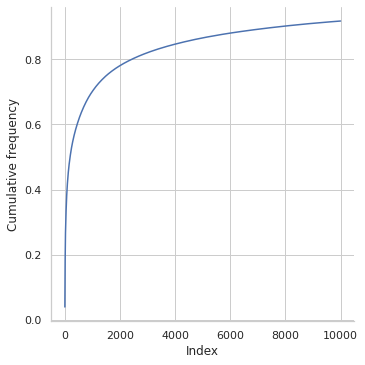

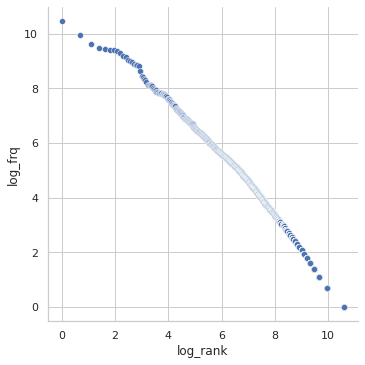

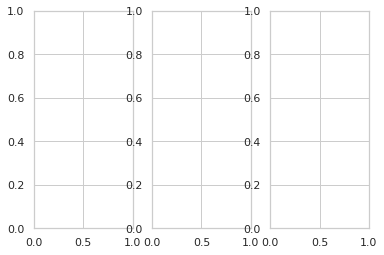

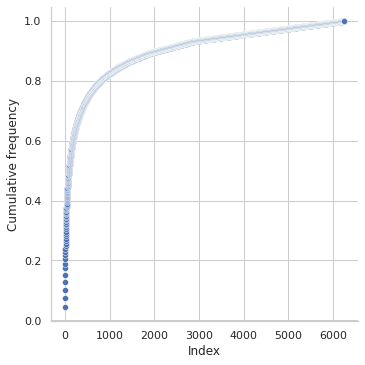

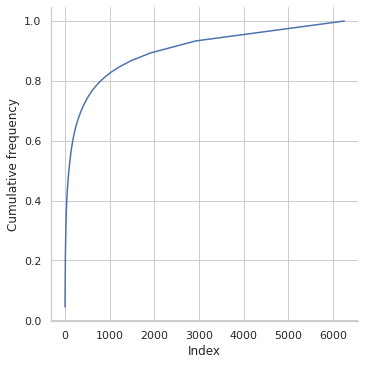

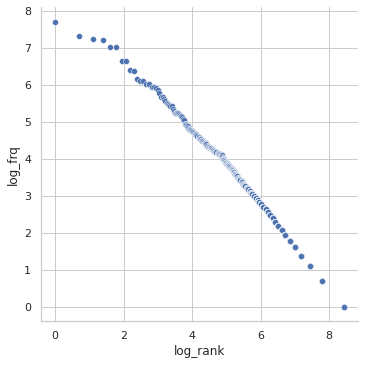

In [25]:
for idx in indexes:
    freq_plot(tokens[idx][0], counters[idx][0])

In [8]:
#Compare the most frequent words with a general word list for English
wordfre = pd.read_excel(r'../data/wordFrequency.xlsx', sheet_name='1 lemmas')
fre_words = pd.DataFrame(wordfre, columns= ['lemma'])
fre_words.head(20)

,lemma
0,the
1,be
2,and
3,a
4,of
5,to
6,in
7,i
8,you
9,it


In [29]:
xd = list(zip(tokens["offensive"][0], tokens["offensive"][0][1:]))
collections.Counter(xd).most_common(20)

[(('you', 'are'), 914),
 (('gun', 'control'), 844),
 (('he', 'is'), 823),
 (('she', 'is'), 768),
 (('is', 'a'), 715),
 (('#', 'MAGA'), 662),
 (('don', 't'), 644),
 (('of', 'the'), 590),
 (('He', 'is'), 545),
 (('She', 'is'), 531),
 (('You', 'are'), 483),
 (('in', 'the'), 480),
 (('I', 'm'), 361),
 (('to', 'be'), 346),
 (('is', 'the'), 333),
 (('it', 's'), 332),
 (('It', 's'), 297),
 (('MAGA', '#'), 295),
 (('to', 'the'), 287),
 (('on', 'the'), 284)]

In [30]:
xd2 = list(zip(tokens["offensive"][0], tokens["offensive"][0][1:], tokens["offensive"][0][2:]))
collections.Counter(xd2).most_common(20)

[(('#', 'MAGA', '#'), 291),
 (('I', 'don', 't'), 167),
 (('She', 'is', 'a'), 115),
 (('He', 'is', 'a'), 98),
 (('gun', 'control', 'laws'), 90),
 (('he', 'is', 'a'), 88),
 (('she', 'is', 'a'), 81),
 (('you', 'are', 'a'), 72),
 (('for', 'gun', 'control'), 64),
 (('don', 't', 'know'), 60),
 (('You', 'are', 'a'), 55),
 (('is', 'going', 'to'), 52),
 (('you', 'don', 't'), 51),
 (('they', 'don', 't'), 51),
 (('a', 'lot', 'of'), 50),
 (('on', 'gun', 'control'), 49),
 (('about', 'gun', 'control'), 48),
 (('gun', 'control', 'and'), 48),
 (('don', 't', 'have'), 47),
 (('that', 'you', 'are'), 46)]